In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/guitar/guitar.csv'
SAMPLES_FOLDER = '../data/guitar/guitar_samples/'
FOLDER_PREFIX = 'guitar'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

SUBSET = True # False
N_EPOCHS = 1 # 30
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

DEPENDENCIES = {
    "delay_feedback"      : "delay_on_off",
    "delay_intensity"     : "delay_on_off",
    "delay_time"          : "delay_on_off",
    "disto_drive"         : "disto_on_off",
    "disto_tone"          : "disto_on_off",
    "filter_frequency"    : "filter_on_off",
    "filter_mode_LBF_HPF" : "filter_on_off",
    "filter_resonance"    : "filter_on_off",
    "flanger_intensity"   : "flanger_on_off",
    "flanger_mode"        : "flanger_on_off",
    "flanger_rate"        : "flanger_on_off",
    "flanger_width"       : "flanger_on_off",
    "reverb_bright"       : "reverb_on_off",
    "reverb_room_size"    : "reverb_on_off"
}

RESULTS-guitar-2018-01-09_21:52.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
if SUBSET:
    Y = Y.head(100)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   flanger_intensity  delay_time  disto_drive  reverb_room_size reverb_on_off  \
0           0.629921    0.944882     2.755906          6.377953           off   
1           5.039370    4.645669     0.078740          4.803150           off   
2           2.440945    0.472441     6.692913          7.086614           off   
3           9.606299    2.283465     9.370079          7.086614           off   
4           7.007874    3.228346     9.921260          4.330709            on   

  delay_on_off  flanger_width  flanger_rate  disto_tone filter_on_off  \
0           on       1.496063      1.653543    7.165354           off   
1           on       9.763780      7.322835    4.960630           off   
2          off       5.275591      8.031496    0.314961            on   
3          off       6.929134      3.622047    7.165354            on   
4           on       7.480315      0.472441    5.984252           off   

   delay_feedback  delay_intensity flanger_on_off  reverb_bright  \
0     

In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
(20, 18522)
Loaded training waveform #0
(80, 18522)


# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(20, 20, 37)
(80, 20, 37)


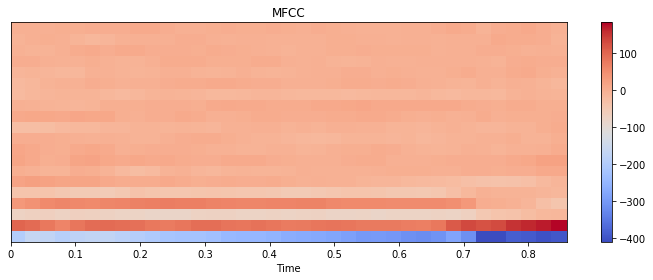

In [7]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[10,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [8]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(20, 740)
(80, 740)


## Predictions

In [9]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

    
def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):

        print 'predicting feature', t_name
        y_train = Y_train[t_name]
        y_test = Y_test[t_name]
        print y_train.dtype
        
        if t_name in DEPENDENCIES:
            switch = DEPENDENCIES[t_name]
            
            to_keep_train = (Y_train[switch] == 'on')
            print 'Keeping', str(sum(to_keep_train)), 'training examples out of',  str(len(to_keep_train))
            y_train = y_train[to_keep_train]
            X_train= X_train_mfcc[to_keep_train,...]
            
            to_keep_test = (Y_test[switch] == 'on')
            print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
            y_test = y_test[to_keep_test]
            X_test = X_test_mfcc[to_keep_test,...]
        
        else:
            X_train= X_train_mfcc
            X_test= X_test_mfcc
        
        print X_train.shape, y_train.shape
        print X_test.shape, y_test.shape
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
           print "Unexpected error:", sys.exc_info()[0]

In [10]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature flanger_intensity
float64
Keeping 40 training examples out of 80
Keeping 10 training examples out of 20
(40, 740) (40,)
(10, 740) (10,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
2.30403631978
4.28871391076
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'disto_drive', 'reg', 2.3040363197848466, 4.2887139107630325)
predicting feature reverb_room_size
float64
Keeping 39 training examples ou

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
0.8875
0.85
('kNN', 'per_output', None, {'n_neighbors': 3}, None, 'reverb_on_off', 'class', 0.88749999999999996, 0.84999999999999998)
predicting feature delay_on_off
object
(80, 740) (80,)
(20, 740) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] ....................

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



float64
Keeping 40 training examples out of 80
Keeping 10 training examples out of 20
(40, 740) (40,)
(10, 740) (10,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] ...................................

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
2.38561396042
1.61679790026
('kNN', 'per_output', {'n_neighbors': 3}, None, None, 'disto_tone', 'reg', 2.3856139604171891, 1.6167979002629664)
predicting feature filter_on_off
object
(80, 740) (80,)
(20, 740) (20,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .........

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] ................................... n_neighbors=16, total=   0.0s
[CV] n_neighbors=16 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished


In [11]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature flanger_intensity
float64
Keeping 40 training examples out of 80
Keeping 10 training examples out of 20
(40, 740) (40,)
(10, 740) (10,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
1.08575049914
0.759842519685
('Decision Tree', 'per_output', {'max_depth': 2}, None, None, 'delay_time', 'reg', 1.0857504991375531, 0.75984251968507788)
predicting feature disto_drive
float64
Keeping 37 training examples out of 80
Keeping 10 training examples out of 20
(37, 740) (37,)
(10, 740) (10,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
3.58161310917
4.17322834646
('Decision Tree', 'per_output', {'max_depth': 32}, None, None, 'disto_drive', 'reg', 3.5816131091721082, 4.1732283464582007)
predicting feature reverb_room_size
float64
Keeping 39 training examples out of 80
Keeping 10 training examples out of 20
(39, 740) (39,)
(10, 740) (10,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 ...............................................

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
2.66286105988
3.99735225404
('Decision Tree', 'per_output', {'max_depth': 2}, None, None, 'reverb_room_size', 'reg', 2.6628610598754059, 3.9973522540445514)
predicting feature reverb_on_off
object
(80, 740) (80,)
(20, 740) (20,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
0.8375
0.9
('Decision Tree', 'per_output', None, {'max_depth': 16}, None, 'reverb_on_off', 'class', 0.83750000000000002, 0.90000000000000002)
predicting feature delay_on_off
object
(80, 740) (80,)
(20, 740) (20,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
0.825
0.95
('Decision Tree', 'per_output', None, {'max_depth': 128}, None, 'd

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished



[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
4.244

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished



[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


3.06884716333
3.38582677165
('Decision Tree', 'per_output', {'max_depth': 64}, None, None, 'delay_feedback', 'reg', 3.0688471633336665, 3.385826771654417)
predicting feature delay_intensity
float64
Keeping 39 training examples out of 80
Keeping 12 training examples out of 20
(39, 740) (39,)
(12, 740) (12,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 ...............................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.0s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
3.14329605047
2.26968503937
('Decision Tree', 'per_output', {'max_depth': 2}, None, None, 'reverb_bright', 'reg', 3.1432960504748175, 2.2696850393696004)
predicting feature filter_resonance
float64
Keeping 44 training examples out of 80
Keeping 10 training examples out of 20
(44, 740) (44,)
(10, 740) (10,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 ..............................................

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
3.06767477929
3.52905886764
('Decision Tree', 'per_output', {'max_depth': 2}, None, None, 'filter_resonance', 'reg', 3.0676747792894008, 3.5290588676402281)
predicting feature flanger_mode
object
Keeping 40 training exa

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
0.575
0.2
('Decision Tree', 'per_output', None, {'max_depth': 8}, None, 'flanger_mode', 'class', 0.57499999999999996, 0.20000000000000001)
predicting feature disto_on_off
object
(80, 740) (80,)
(20, 740) (20,)
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.0s
[CV] max_depth=2 ...

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
2.6395

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=32 ....................................................
[CV] ..................................... max_depth=32, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=64 ....................................................
[CV] ..................................... max_depth=64, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .................................... max_depth=128, total=   0.0s
[CV] max_depth=128 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished


In [12]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature flanger_intensity
float64
Keeping 40 training examples out of 80
Keeping 10 training examples out of 20
(40, 740) (40,)
(10, 740) (10,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.12455414227
2.52047244095
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'flanger_intensity', 'reg', 2.1245541422697625, 2.5204724409465298)
predicting feature delay_time
float64
Keeping 39 training examples out of 80
Keeping 12 training examples out of 20
(39, 740) (39,)
(12, 740) (12,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]

 (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
0.5125
0.5
('Naive', 'per_output', None, {'strategy': 'most_frequent'}, None, 'reverb_on_off', 'class', 0.51249999999999996, 0.5)
predicting feature delay_on_off
object
(80, 740) (80,)
(20, 740) (20,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=most_frequent ..........................................
[CV] ........................... strategy=most_frequent, total=   0.0s
[CV] strategy=most_frequent ..........................................
[CV] ........................... st

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


[CV] .................................... strategy=mean, total=   0.0s
2.40242898632
2.67716535433
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'delay_feedback', 'reg', 2.4024289863170258, 2.6771653543313669)
predicting feature delay_intensity
float64
Keeping 39 training examples out of 80
Keeping 12 training examples out of 20
(39, 740) (39,)
(12, 740) (12,)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.63896007082
3.59697826233
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'delay_intensity', 'reg', 2.6389600708190493, 3.596978

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]

In [13]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling

In [14]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

flanger_intensity
delay_time
disto_drive
reverb_room_size
reverb_on_off
delay_on_off
flanger_width
flanger_rate
disto_tone
filter_on_off
delay_feedback
delay_intensity
flanger_on_off
reverb_bright
filter_resonance
flanger_mode
disto_on_off
filter_mode_LBF_HPF
filter_frequency
OrderedDict([('flanger_intensity', {'sd': 2.7404339336962433, 'type': dtype('float64'), 'mean': 4.7539370078740504}), ('delay_time', {'sd': 1.4830475987342422, 'type': dtype('float64'), 'mean': 2.4753937007878237}), ('disto_drive', {'sd': 3.0661834312732408, 'type': dtype('float64'), 'mean': 5.1427165354327284}), ('reverb_room_size', {'sd': 2.8299924556370386, 'type': dtype('float64'), 'mean': 4.8395669291343166}), ('reverb_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('delay_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('flanger_width', {'sd': 2.9778071184466022, 'type': dtype('float64'), 'mean': 5.4921259842

In [15]:
# Preps input data
X_train_mfcc = X_train_mfcc.reshape([X_train_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)
X_test_mfcc = X_test_mfcc.reshape([X_test_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)

print ''
print X_train_mfcc.shape
print X_test_mfcc.shape


(80, 37, 20)
(20, 37, 20)


In [16]:
from keras.callbacks import EarlyStopping

def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():

        # Normalizes/one-hot encodes
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1        
        else:
            raise ValueError
        
        # Sets to zero if necessary
        if name in DEPENDENCIES:
            switch = DEPENDENCIES[name]
            is_off = Y[switch] == "off"
            print 'Setting', str(sum(is_off)),'elements to zero'
            y[is_off] = 0
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model, X_train, X_test):
    
    # Prepares input and output data
    X_mean = np.mean(X_train, axis=(0))
    X_sd = np.std(X_train, axis=(0))
    
    X_train = (X_train - X_mean) / X_sd
    X_test  = (X_test - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=25)
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION, callbacks=[early_stopping])
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        print 'Output:', j
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        truth = Y_test[t_name]
        print t_name
        print Y_pred.shape
        
        if t_name in DEPENDENCIES:
            switch = DEPENDENCIES[t_name]
            
            to_keep_test = (Y_test[switch] == 'on')
            print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
            truth = truth[to_keep_test]
            Y_pred = Y_pred[to_keep_test,...]
            print Y_pred.shape, truth.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, truth)
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, truth)

        else:
            raise ValueError
        
        train_scores = -1 * hist.history['val_loss'][-1]
        out = (label, 'joint', params1, params2, regul,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    return Y

Using TensorFlow backend.


In [17]:
def NN_output(h_layer):
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    
    # Adds on/off switches
    switches = []
    for name,infos in Y_info.iteritems():
        if not name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            switches.append(name)
            out_layers.append(out_layer)
            
        if not name in DEPENDENCIES and infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            switches.append(name)
            out_layers.append(out_layer)
            
    # Adds dependent switches and knobs
    dependent = []
    for name,infos in Y_info.iteritems():
        
        if not name in DEPENDENCIES.values() and infos['type'] == 'float64':
            pred_layer = Dense(1)(h_layer)
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            out_layers.append(out_layer)
            dependent.append(name)

        
        if not name in DEPENDENCIES.values() and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            pred_layer = Dense(out_dim, activation='softmax')(h_layer)            
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            out_layers.append(out_layer)
            dependent.append(name)
        
    # Reorders everything
    all_out = switches + dependent
    ord_out = []
    for out_name in Y_info:
        o = out_layers[all_out.index(out_name)]
        ord_out.append(o)

    return ord_out, metrics, losses

In [20]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten, Multiply, Lambda, RepeatVector
from keras import backend as K
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

# for N_LAYERS in [1,2]:
#     for N_UNITS in [64,90,128]:
#         for REGUL in [0]:
for N_LAYERS in [1]:
    for N_UNITS in [64]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 740)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           47424       flatten_1[0][0]                  
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            130         dense_1[0][0]                    
__________________________________________________________________________________________________
delay_on_o

Setting 8 elements to zero
delay_time (20,)
Setting 10 elements to zero
disto_drive (20,)
Setting 10 elements to zero
reverb_room_size (20,)
reverb_on_off (20, 2)
delay_on_off (20, 2)
Setting 10 elements to zero
flanger_width (20,)
Setting 10 elements to zero
flanger_rate (20,)
Setting 10 elements to zero
disto_tone (20,)
filter_on_off (20, 2)
Setting 8 elements to zero
delay_feedback (20,)
Setting 8 elements to zero
delay_intensity (20,)
flanger_on_off (20, 2)
Setting 10 elements to zero
reverb_bright (20,)
Setting 10 elements to zero
filter_resonance (20,)
Setting 10 elements to zero
flanger_mode (20, 3)
disto_on_off (20, 2)
Setting 10 elements to zero
filter_mode_LBF_HPF (20,)
Setting 10 elements to zero
filter_frequency (20,)
Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s 7ms/step
Output: 0
flanger_intensity
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('MLP', 'joint', 64, 1, 0, 'flanger_intensity', 'reg', -15.221785

In [21]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, dropout=regul)(h_layer)
        
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

# for N_LAYERS in [1,2]:
#     for N_UNITS in [32,64,80,128]:
#         for REGUL in [0,0.2]:
for N_LAYERS in [1]:
    for N_UNITS in [32]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           6784        input_2[0][0]                    
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            66          lstm_1[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            66          lstm_1[0][0]                     
__________________________________________________________________________________________________
disto_on_o

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s 15ms/step
Output: 0
flanger_intensity
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('LSTM', 'joint', 32, 1, 0, 'flanger_intensity', 'reg', -11.076255798339844, 2.3793933286451479)
Output: 1
delay_time
(20, 1)
Keeping 12 training examples out of 20
(12, 1) (12,)
('LSTM', 'joint', 32, 1, 0, 'delay_time', 'reg', -11.076255798339844, 1.3662700399634558)
Output: 2
disto_drive
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('LSTM', 'joint', 32, 1, 0, 'disto_drive', 'reg', -11.076255798339844, 2.6840793538291896)
Output: 3
reverb_room_size
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('LSTM', 'joint', 32, 1, 0, 'reverb_room_size', 'reg', -11.076255798339844, 2.9063623482790311)
Output: 4
reverb_on_off
(20, 2)
('LSTM', 'joint', 32, 1, 0, 'reverb_on_off', 'class', -11.076255798339844, 0.5)
Output: 5
delay_on_off
(20, 2)
('LSTM', 'joint', 32, 1, 0, 'delay

In [22]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul, in_shape):
    # Input layer
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer_full)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

# for N_FILTERS in [16,32,48,64]:
#     for N_LAYERS in [1,2]:
#         for REGUL in [0]:
for N_FILTERS in [16]:
    for N_LAYERS in [1]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

(37, 20)
0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 34, 16)       1296        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 16, 16)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 16)           0           max_pooling1d_1[0][0]            
__________________________________________________________________________________________________

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 0s 20ms/step
Output: 0
flanger_intensity
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('Conv', 'joint', 16, 1, 0, 'flanger_intensity', 'reg', -23.11149787902832, 9.3383145805411996)
Output: 1
delay_time
(20, 1)
Keeping 12 training examples out of 20
(12, 1) (12,)
('Conv', 'joint', 16, 1, 0, 'delay_time', 'reg', -23.11149787902832, 3.9622311392643517)
Output: 2
disto_drive
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('Conv', 'joint', 16, 1, 0, 'disto_drive', 'reg', -23.11149787902832, 4.3736921659615833)
Output: 3
reverb_room_size
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('Conv', 'joint', 16, 1, 0, 'reverb_room_size', 'reg', -23.11149787902832, 2.0551249239394638)
Output: 4
reverb_on_off
(20, 2)
('Conv', 'joint', 16, 1, 0, 'reverb_on_off', 'class', -23.11149787902832, 0.5)
Output: 5
delay_on_off
(20, 2)
('Conv', 'joint', 16, 1, 0, 'delay_on_o

# Mid level features

In [23]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

flanger_intensity
delay_time
disto_drive
reverb_room_size
reverb_on_off
delay_on_off
flanger_width
flanger_rate
disto_tone
filter_on_off
delay_feedback
delay_intensity
flanger_on_off
reverb_bright
filter_resonance
flanger_mode
disto_on_off
filter_mode_LBF_HPF
filter_frequency
OrderedDict([('flanger_intensity', {'sd': 2.7404339336962433, 'type': dtype('float64'), 'mean': 4.7539370078740504}), ('delay_time', {'sd': 1.4830475987342422, 'type': dtype('float64'), 'mean': 2.4753937007878237}), ('disto_drive', {'sd': 3.0661834312732408, 'type': dtype('float64'), 'mean': 5.1427165354327284}), ('reverb_room_size', {'sd': 2.8299924556370386, 'type': dtype('float64'), 'mean': 4.8395669291343166}), ('reverb_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('delay_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('flanger_width', {'sd': 2.9778071184466022, 'type': dtype('float64'), 'mean': 5.4921259842

In [24]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

(20, 32, 37)
(80, 32, 37)


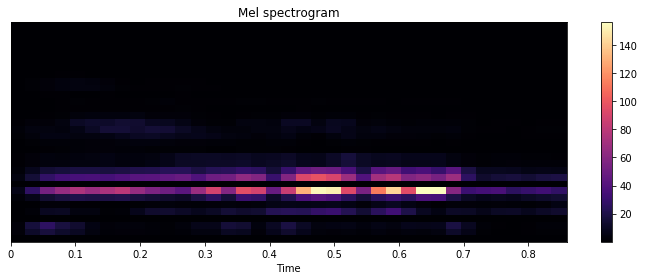

In [25]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [26]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

(80, 37, 32) (20, 37, 32)


In [31]:
# for N_LAYERS in [1,2]:
#     for N_UNITS in [64,90,128]:
#         for REGUL in [0]:
for N_LAYERS in [1]:
    for N_UNITS in [64]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 37, 32)       0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 1184)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_89 (Dense)                (None, 64)           75840       flatten_3[0][0]                  
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            130         dense_89[0][0]                   
__________________________________________________________________________________________________
delay_on_o

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s 43ms/step
Output: 0
flanger_intensity
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('MLP_mid', 'joint', 64, 1, 0, 'flanger_intensity', 'reg', -9.6273069381713867, 2.8006922755667119)
Output: 1
delay_time
(20, 1)
Keeping 12 training examples out of 20
(12, 1) (12,)
('MLP_mid', 'joint', 64, 1, 0, 'delay_time', 'reg', -9.6273069381713867, 1.4683747634169775)
Output: 2
disto_drive
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('MLP_mid', 'joint', 64, 1, 0, 'disto_drive', 'reg', -9.6273069381713867, 2.8794359376127945)
Output: 3
reverb_room_size
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('MLP_mid', 'joint', 64, 1, 0, 'reverb_room_size', 'reg', -9.6273069381713867, 2.4891535098162012)
Output: 4
reverb_on_off
(20, 2)
('MLP_mid', 'joint', 64, 1, 0, 'reverb_on_off', 'class', -9.6273069381713867, 0.75)
Output: 5
delay_on_off
(20, 2)
('MLP_mid', 'joint

In [32]:
# for N_LAYERS in [1,2]:
#     for N_UNITS in [32,64,80,128]:
#         for REGUL in [0,0.2]:
for N_LAYERS in [1]:
    for N_UNITS in [32]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 37, 32)       0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 32)           8320        input_8[0][0]                    
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            66          lstm_3[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            66          lstm_3[0][0]                     
__________________________________________________________________________________________________
disto_on_o

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s 56ms/step
Output: 0
flanger_intensity
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('LSTM_mid', 'joint', 32, 1, 0, 'flanger_intensity', 'reg', -10.343520164489746, 2.5440839423917909)
Output: 1
delay_time
(20, 1)
Keeping 12 training examples out of 20
(12, 1) (12,)
('LSTM_mid', 'joint', 32, 1, 0, 'delay_time', 'reg', -10.343520164489746, 1.4634069944299577)
Output: 2
disto_drive
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('LSTM_mid', 'joint', 32, 1, 0, 'disto_drive', 'reg', -10.343520164489746, 2.5984635281761133)
Output: 3
reverb_room_size
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('LSTM_mid', 'joint', 32, 1, 0, 'reverb_room_size', 'reg', -10.343520164489746, 2.6621981436815578)
Output: 4
reverb_on_off
(20, 2)
('LSTM_mid', 'joint', 32, 1, 0, 'reverb_on_off', 'class', -10.343520164489746, 0.5)
Output: 5
delay_on_off
(20, 2)
('LSTM_mid', '

In [33]:
# for N_FILTERS in [16,32,48,64]:
#     for N_LAYERS in [1,2]:
#         for REGUL in [0]:
for N_FILTERS in [16]:
    for N_LAYERS in [1]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv_mid', N_FILTERS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

(37, 32)
0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 37, 32)       0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 34, 16)       2064        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 16, 16)       0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalM (None, 16)           0           max_pooling1d_3[0][0]            
__________________________________________________________________________________________________

Train on 72 samples, validate on 8 samples
Epoch 1/1
20/20 [==============================] - 1s 53ms/step
Output: 0
flanger_intensity
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('Conv_mid', 'joint', 16, 1, 0, 'flanger_intensity', 'reg', -17.095863342285156, 2.567413634953879)
Output: 1
delay_time
(20, 1)
Keeping 12 training examples out of 20
(12, 1) (12,)
('Conv_mid', 'joint', 16, 1, 0, 'delay_time', 'reg', -17.095863342285156, 1.506948286779455)
Output: 2
disto_drive
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('Conv_mid', 'joint', 16, 1, 0, 'disto_drive', 'reg', -17.095863342285156, 2.7539234090049707)
Output: 3
reverb_room_size
(20, 1)
Keeping 10 training examples out of 20
(10, 1) (10,)
('Conv_mid', 'joint', 16, 1, 0, 'reverb_room_size', 'reg', -17.095863342285156, 2.6781563098039944)
Output: 4
reverb_on_off
(20, 2)
('Conv_mid', 'joint', 16, 1, 0, 'reverb_on_off', 'class', -17.095863342285156, 0.5)
Output: 5
delay_on_off
(20, 2)
('Conv_mid', 'jo

# Visualizing the results

      algo  type param1 param2 regularization train_score
1     Conv joint     16      1              0  -21.212678
2 Conv_mid joint     16      1              0  -17.095863
3     LSTM joint     32      1              0  -10.779656
4 LSTM_mid joint     32      1              0  -10.343520
5      MLP joint     64      1              0  -12.754986
6  MLP_mid joint     64      1              0   -9.627307
            algo metric     score
1           Conv  class 0.4666667
2           Conv    reg 3.9335432
3       Conv_mid  class 0.4166667
4       Conv_mid    reg 2.8168654
5  Decision Tree  class 0.7250000
6  Decision Tree    reg 2.8540130
7           LSTM  class 0.4500000
8           LSTM    reg 2.4051461
9       LSTM_mid  class 0.4333333
10      LSTM_mid    reg 2.3959943
11           MLP  class 0.6083333
12           MLP    reg 2.6935297
13       MLP_mid  class 0.6250000
14       MLP_mid    reg 2.5972071
15         Naive  class 0.4500000
16         Naive    reg 2.4044956
17           kNN

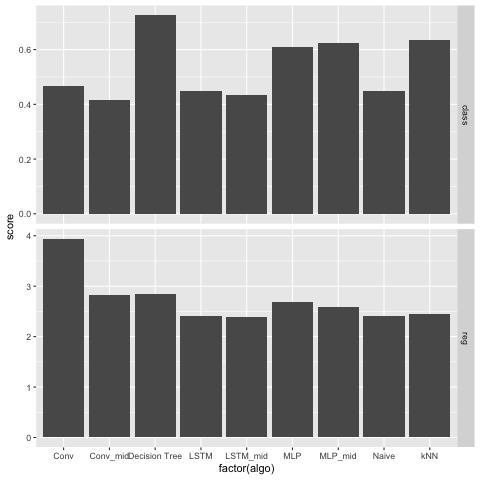

In [34]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
